In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º Î°úÎìúÌï©ÎãàÎã§. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow import keras

print('Ïäù=3')

Ïäù=3


# KITTI Îç∞Ïù¥ÌÑ∞ÏÖã ÏàòÏßëÍ≥º Íµ¨Ï∂ï

In [3]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGeneratorÎäî tf.keras.utils.SequenceÎ•º ÏÉÅÏÜçÎ∞õÏäµÎãàÎã§.
    Ïö∞Î¶¨Í∞Ä KittiDatasetÏùÑ ÏõêÌïòÎäî Î∞©ÏãùÏúºÎ°ú preprocessÌïòÍ∏∞ ÏúÑÌï¥ÏÑú SequnceÎ•º Ïª§Ïä§ÌÖÄÌï¥ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    '''
    def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: datasetÏùò directory pathÏûÖÎãàÎã§.
        batch_size: batch_sizeÏûÖÎãàÎã§.
        img_size: preprocessÏóê ÏÇ¨Ïö©Ìï† ÏûÖÎ†•Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞ÏûÖÎãàÎã§.
        output_size: ground_truthÎ•º ÎßåÎì§Ïñ¥Ï£ºÍ∏∞ ÏúÑÌïú ÌÅ¨Í∏∞ÏûÖÎãàÎã§.
        is_train: Ïù¥ GeneratorÍ∞Ä ÌïôÏäµÏö©Ïù∏ÏßÄ ÌÖåÏä§Ìä∏Ïö©Ïù∏ÏßÄ Íµ¨Î∂ÑÌï©ÎãàÎã§.
        augmentation: Ï†ÅÏö©ÌïòÍ∏∏ ÏõêÌïòÎäî augmentation Ìï®ÏàòÎ•º Ïù∏ÏûêÎ°ú Î∞õÏäµÎãàÎã§.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()ÏùÑ ÌÜµÌï¥ÏÑú kitti datasetÏùò directory pathÏóêÏÑú ÎùºÎ≤®Í≥º Ïù¥ÎØ∏ÏßÄÎ•º ÌôïÏù∏Ìï©ÎãàÎã§.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti datasetÏóêÏÑú ÌïÑÏöîÌïú Ï†ïÎ≥¥(Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°ú Î∞è ÎùºÎ≤®)Î•º directoryÏóêÏÑú ÌôïÏù∏ÌïòÍ≥† Î°úÎìúÌïòÎäî Ìï®ÏàòÏûÖÎãàÎã§.
        # Ïù¥Îïå is_trainÏóê Îî∞Îùº test setÏùÑ Î∂ÑÎ¶¨Ìï¥ÏÑú loadÌïòÎèÑÎ°ù Ìï¥ÏïºÌï©ÎãàÎã§.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # GeneratorÏùò lengthÎ°úÏÑú Ï†ÑÏ≤¥ datasetÏùÑ batch_sizeÎ°ú ÎÇòÎàÑÍ≥† ÏÜåÏà´Ï†ê Ï≤´Ïß∏ÏûêÎ¶¨ÏóêÏÑú Ïò¨Î¶ºÌïú Í∞íÏùÑ Î∞òÌôòÌï©ÎãàÎã§.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # ÏûÖÎ†•Í≥º Ï∂úÎ†•ÏùÑ ÎßåÎì≠ÎãàÎã§.
        # ÏûÖÎ†•ÏùÄ resizeÎ∞è augmentationÏù¥ Ï†ÅÏö©Îêú input imageÏù¥Í≥† 
        # Ï∂úÎ†•ÏùÄ semantic labelÏûÖÎãàÎã§.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
        # Ìïú epochÍ∞Ä ÎÅùÎÇòÎ©¥ Ïã§ÌñâÎêòÎäî Ìï®ÏàòÏûÖÎãàÎã§. ÌïôÏäµÏ§ëÏù∏ Í≤ΩÏö∞Ïóê ÏàúÏÑúÎ•º random shuffleÌïòÎèÑÎ°ù Ï†ÅÏö©Ìïú Í≤ÉÏùÑ Î≥º Ïàò ÏûàÏäµÎãàÎã§.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [4]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # ÌõàÎ†®Ïö© Îç∞Ïù¥ÌÑ∞Ïùº Í≤ΩÏö∞
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%Ïùò ÌôïÎ•†Î°ú Ï¢åÏö∞ÎåÄÏπ≠
                    RandomSizedCrop(         # 50%Ïùò ÌôïÎ•†Î°ú RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # ÏûÖÎ†•Ïù¥ÎØ∏ÏßÄÎ•º 224X224Î°ú resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # ÌÖåÏä§Ìä∏Ïö© Îç∞Ïù¥ÌÑ∞Ïùº Í≤ΩÏö∞ÏóêÎäî 224X224Î°ú resizeÎßå ÏàòÌñâÌï©ÎãàÎã§. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [5]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# U-Net ++ Î™®Îç∏Ïùò Íµ¨ÌòÑ

Ï∞∏Í≥† ÏûêÎ£åÎì§
- [UNet++: Implementation of the UNet++ architecture on TensorFlow for segmentation of cell nuclei (Medium)](https://medium.com/mlearning-ai/unet-implementation-of-the-unet-architecture-on-tensorflow-for-segmentation-of-cell-nuclei-528b5b6e6ffd)
- [Ï∞∏Í≥† Github](https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py#L199)

In [6]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations
from tensorflow import keras

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


## UNet++ Íµ¨Ï°∞ Ïù¥Ìï¥ÌïòÍ∏∞
---

![U-net++](asset/UNet++.png)   

>U-NetÏóê DenseNetÏùò ÏïÑÏù¥ÎîîÏñ¥Í∞Ä Ï∞®Ïö©Îêú Î≤ÑÏ†Ñ.   

![U-net++ ÏÉÅÏÑ∏ÏÑ§Î™Ö](asset/UNet++_ÏÉÅÏÑ∏ÏÑ§Î™Ö.png)

U-net Íµ¨ÌòÑÌïòÍ≥† ÏàòÏ†ïÌï¥Î≥¥Ïûê

## U-net Íµ¨ÌòÑ

In [105]:
def ConvBlock(x, n_filters):
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    return x

def EncoderBlock(x, n_filters):
    p = ConvBlock(x, n_filters)
    x = keras.layers.MaxPooling2D(2)(p)
    
    return x, p

def DecoderBlock(x, skip, n_filters):
    x = keras.layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(x)
    x = keras.layers.Concatenate()([x, skip]) 
    x = ConvBlock(x, n_filters)
    
    return x

def Unet(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    # Ï∂ïÏÜå Í≤ΩÎ°ú
    skips = []
    
    filters = [64, 128, 256, 512, 1024]
    for i, f in enumerate(filters):
        if i == 0:
            x, p = EncoderBlock(inputs, f)
            skips.append(p)
        elif i == len(filters)-1:
            x = ConvBlock(x, f)
        else:
            x, p = EncoderBlock(x, f)
            skips.append(p)
    
    # ÌôïÏû• Í≤ΩÎ°ú
    for skip, f in zip(skips[::-1], filters[:-1][::-1]):
        x = DecoderBlock(x, skip, f)
    
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'
        
    outputs = keras.layers.Conv2D(num_classes, 1, padding='same', activation=activation)(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

In [106]:
unet = Unet(img_size=(224, 224), num_classes=1)

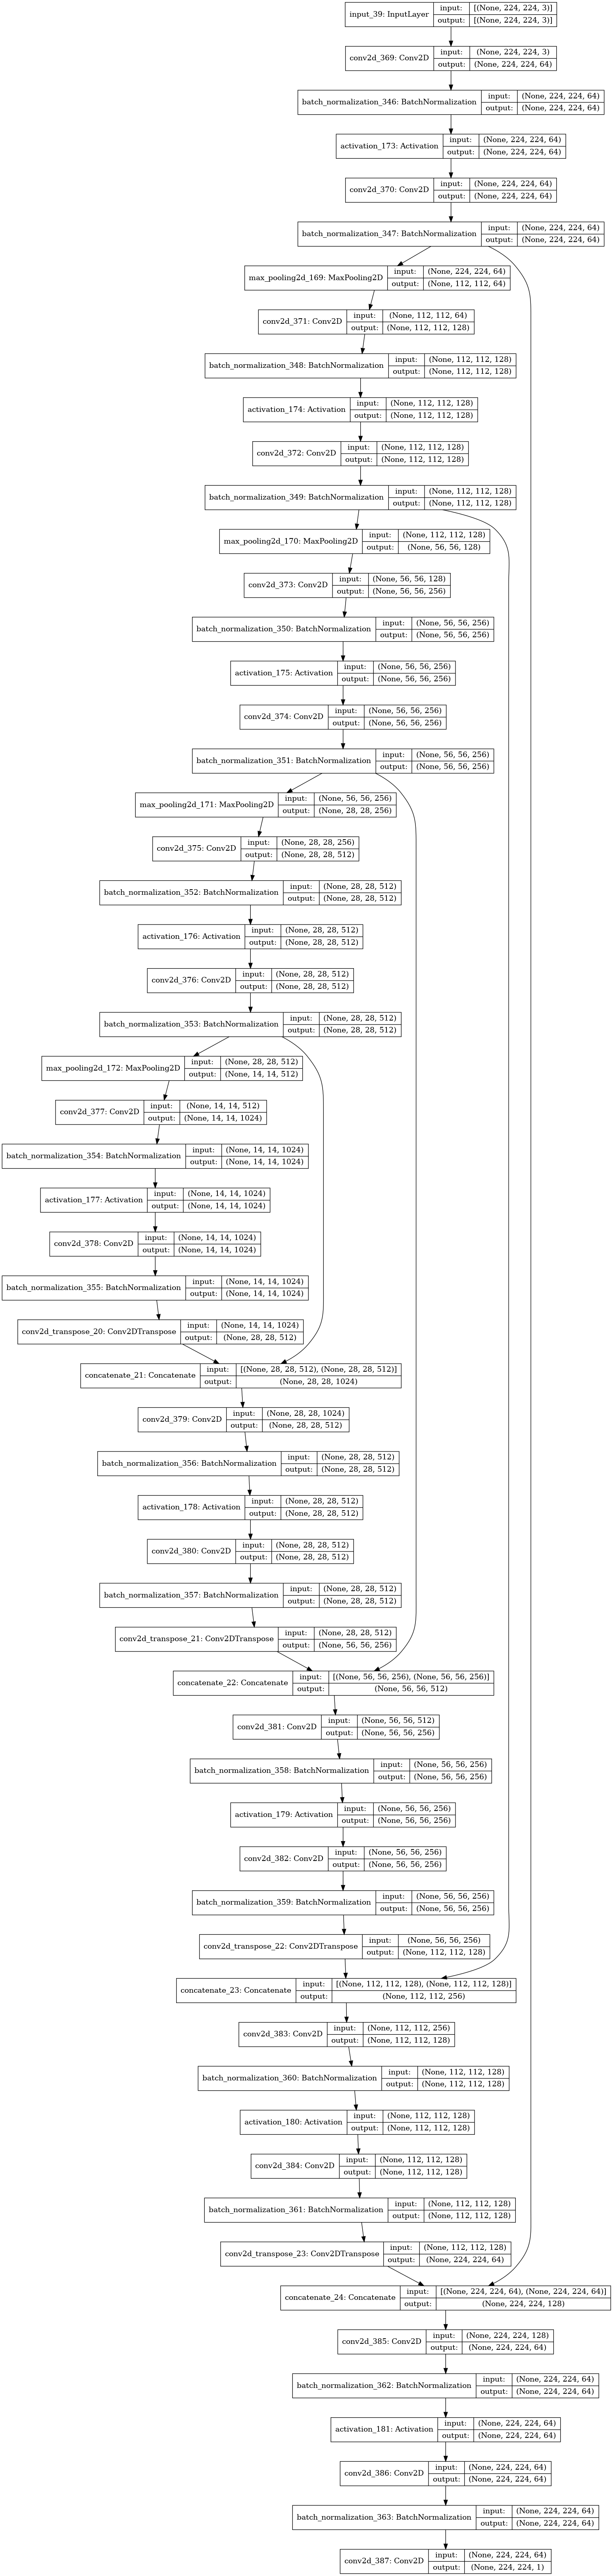

In [108]:
keras.utils.plot_model(unet, show_shapes=True)

In [112]:
# !pip install visualkeras

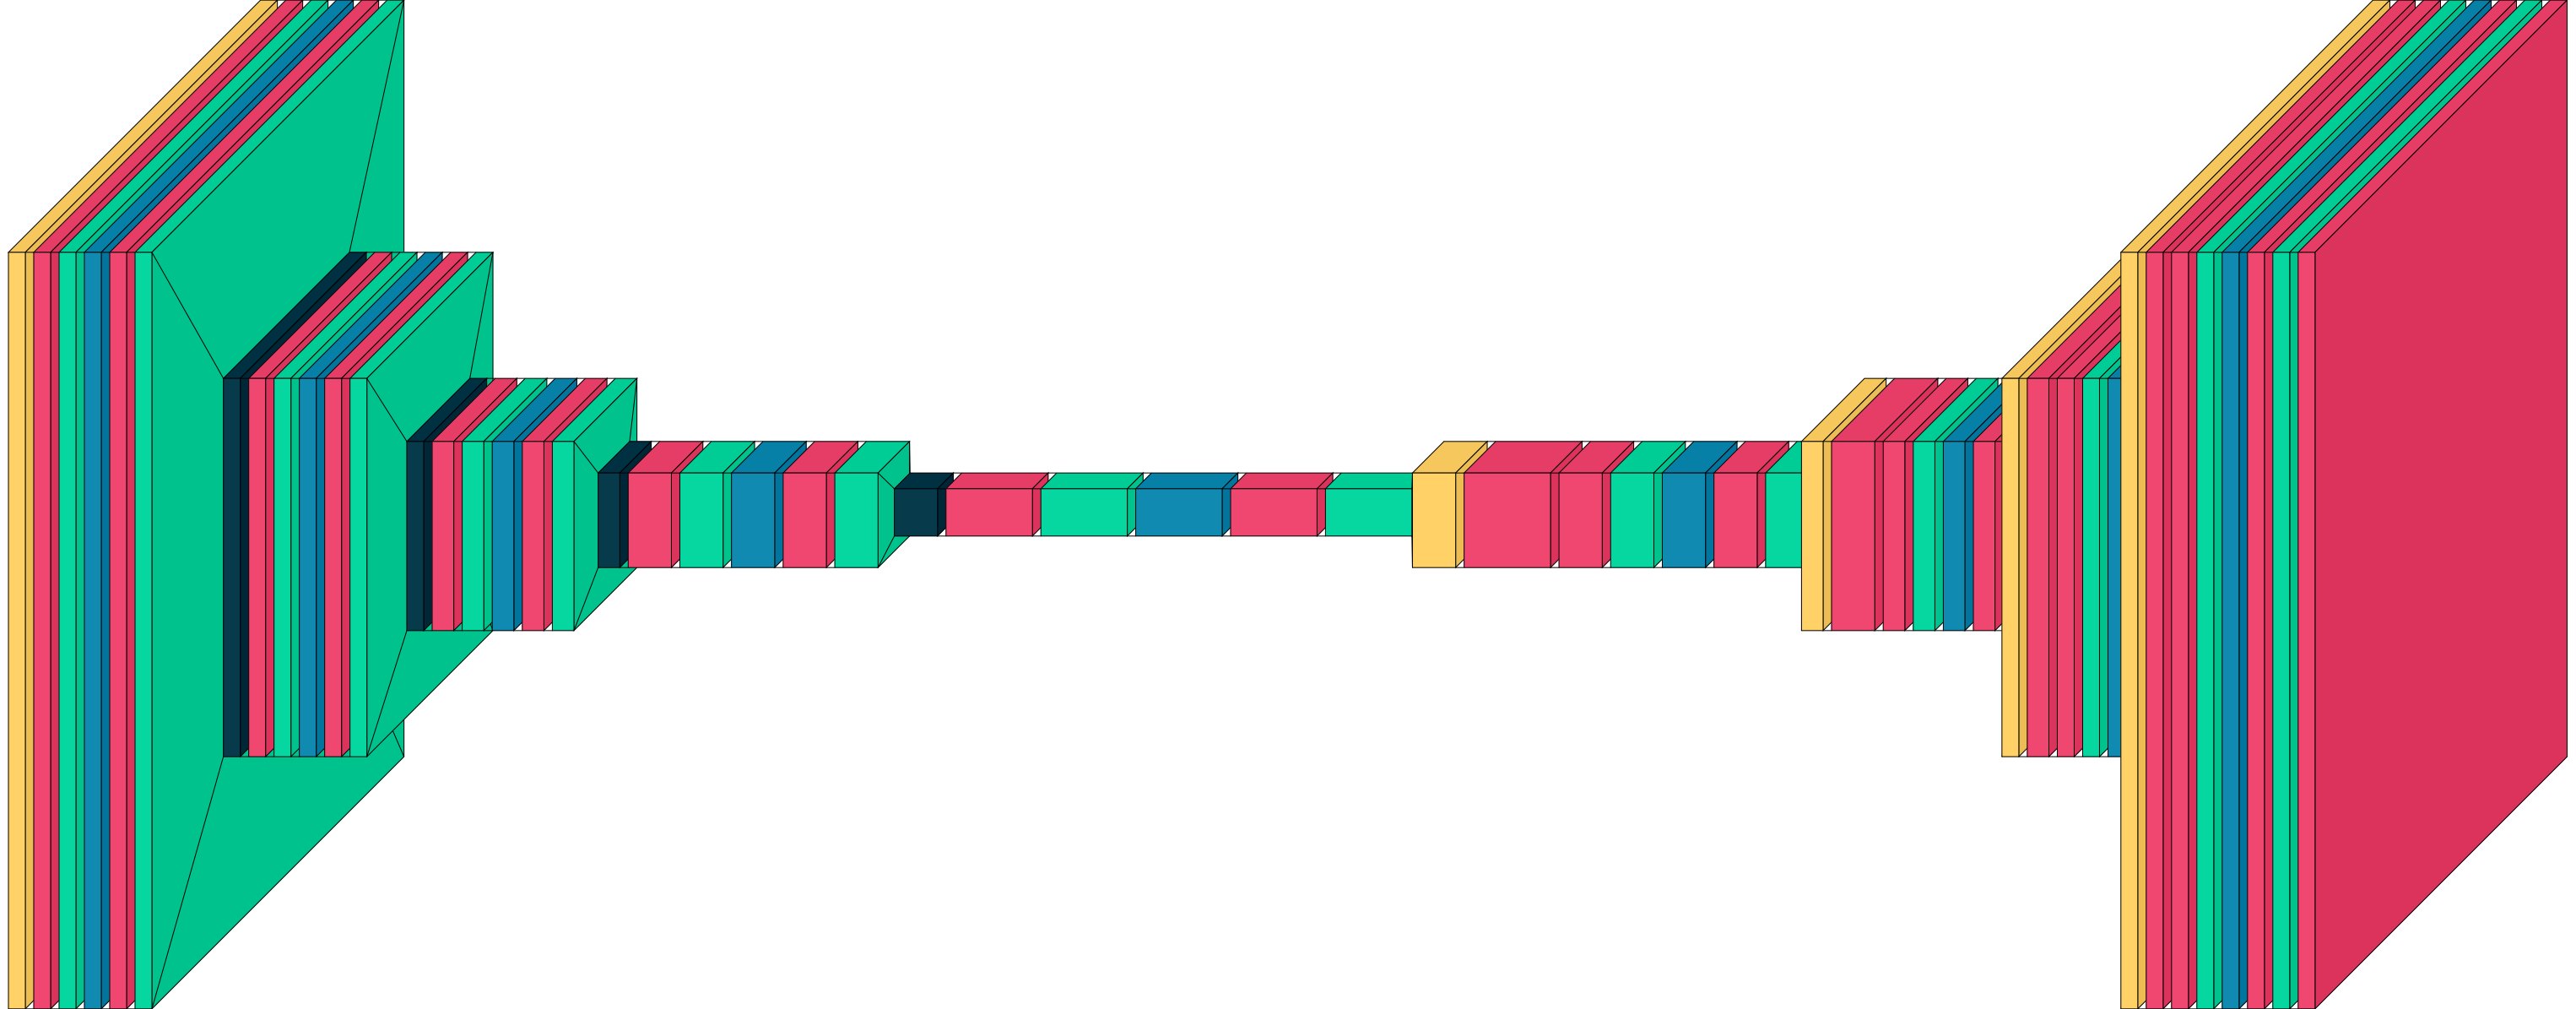

In [116]:
import visualkeras

visualkeras.layered_view(unet)
# Ïó∞Í≤∞ Íµ¨Ï°∞Í∞Ä ÏïàÎÇòÏôÄÏÑú ÏïÑÏâΩÎã§

## U-net++ Íµ¨ÌòÑ

Ïñ¥Î†µÎÑ§...   
Îã®Í≥ÑÎ≥ÑÎ°ú Íµ¨ÌòÑÌïòÏûê

In [176]:
def ConvBlock(x, n_filters):
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    return x

def EncoderBlock(x, n_filters):
    p = ConvBlock(x, n_filters)
    x = keras.layers.MaxPooling2D(2)(p)
    
    return x, p 

def DecoderBlock(x, skip, n_filters):
    x = keras.layers.Concatenate()([x, *skip]) 
    x = ConvBlock(x, n_filters)
    x = UpBlock(x, n_filters)
    
    return x

def UpBlock(x, n_filters):
    x = keras.layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(x)
    
    return x

### U-net++ L1
---
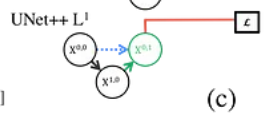

In [130]:
img_size=(224, 224)
num_classes=1
filters = [64, 128, 256, 512, 1024]

inputs = keras.Input(shape=img_size + (3,))

# Î≥ÄÏàòÎ™Ö Ï†ïÎ¶¨
# ÏïÑÎûòÎ°ú Í∞ÄÎäî Í≤ÉÎì§ x, ÏòÜÏúºÎ°ú Í∞ÄÎäî Í≤ÉÎì§  p, ÏúÑÎ°ú Í∞ÄÎäî Í≤ÉÎì§ u, Ìï©Ï≥êÏßÑ Ïù∏Ìíã i

# X_0_0
x_0_0, p_0_0 = EncoderBlock(inputs, filters[0])
# X_1_0
u_1_0 = UpBlock(x_0_0, filters[1])
# X_0_1
i_0_1 =  keras.layers.Concatenate()([p_0_0, u_1_0]) 

output_0_1 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_1)

UNet_pp_L1 = keras.Model(inputs, output_0_1)

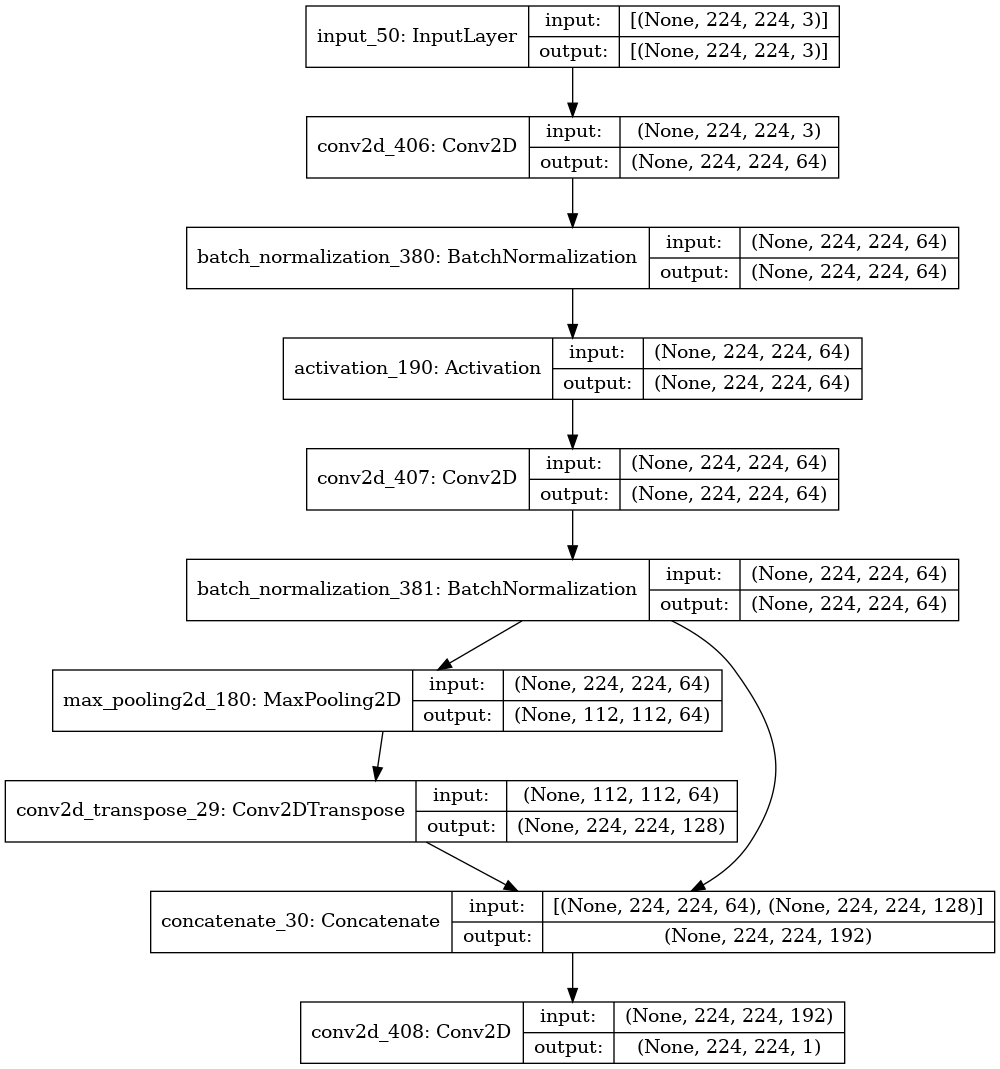

In [131]:
keras.utils.plot_model(UNet_pp_L1, show_shapes=True)

### U-net++ L2
---
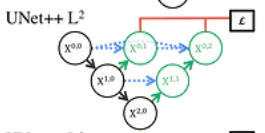

In [136]:
img_size=(224, 224)
num_classes=1
filters = [64, 128, 256, 512, 1024]

inputs = keras.Input(shape=img_size + (3,))

# Î≥ÄÏàòÎ™Ö Ï†ïÎ¶¨
# ÏïÑÎûòÎ°ú Í∞ÄÎäî Í≤ÉÎì§ x, ÏòÜÏúºÎ°ú Í∞ÄÎäî Í≤ÉÎì§  p, ÏúÑÎ°ú Í∞ÄÎäî Í≤ÉÎì§ u, Ìï©Ï≥êÏßÑ Ïù∏Ìíã i, Ï∂úÎ†•Í∞í o
# xÏôÄ p Ï∞®Ïù¥Îäî max pooling Ï†ÅÏö© Ïó¨Î∂Ä

# X_0_0
x_0_0, p_0_0 = EncoderBlock(inputs, filters[0])

# X_1_0
u_1_0 = UpBlock(x_0_0, filters[1])
x_1_0, p_1_0 = EncoderBlock(x_0_0, filters[1])

# X_2_0
u_2_0 = UpBlock(x_1_0, filters[2])

# X_0_1
i_0_1 =  keras.layers.Concatenate()([p_0_0, u_1_0]) 
o_0_1 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_1)
p_0_1 = ConvBlock(i_0_1, filters[1])

# X_1_1
i_1_1 =  keras.layers.Concatenate()([p_1_0, u_2_0]) 
u_1_1 = UpBlock(i_1_1, filters[2])

# X_0_2
i_0_2 =  keras.layers.Concatenate()([p_0_1, u_1_1, p_0_0]) 
o_0_2 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_2)

outputs = keras.layers.Average()([o_0_1, o_0_2])
UNet_pp_L2 = keras.Model(inputs, outputs)

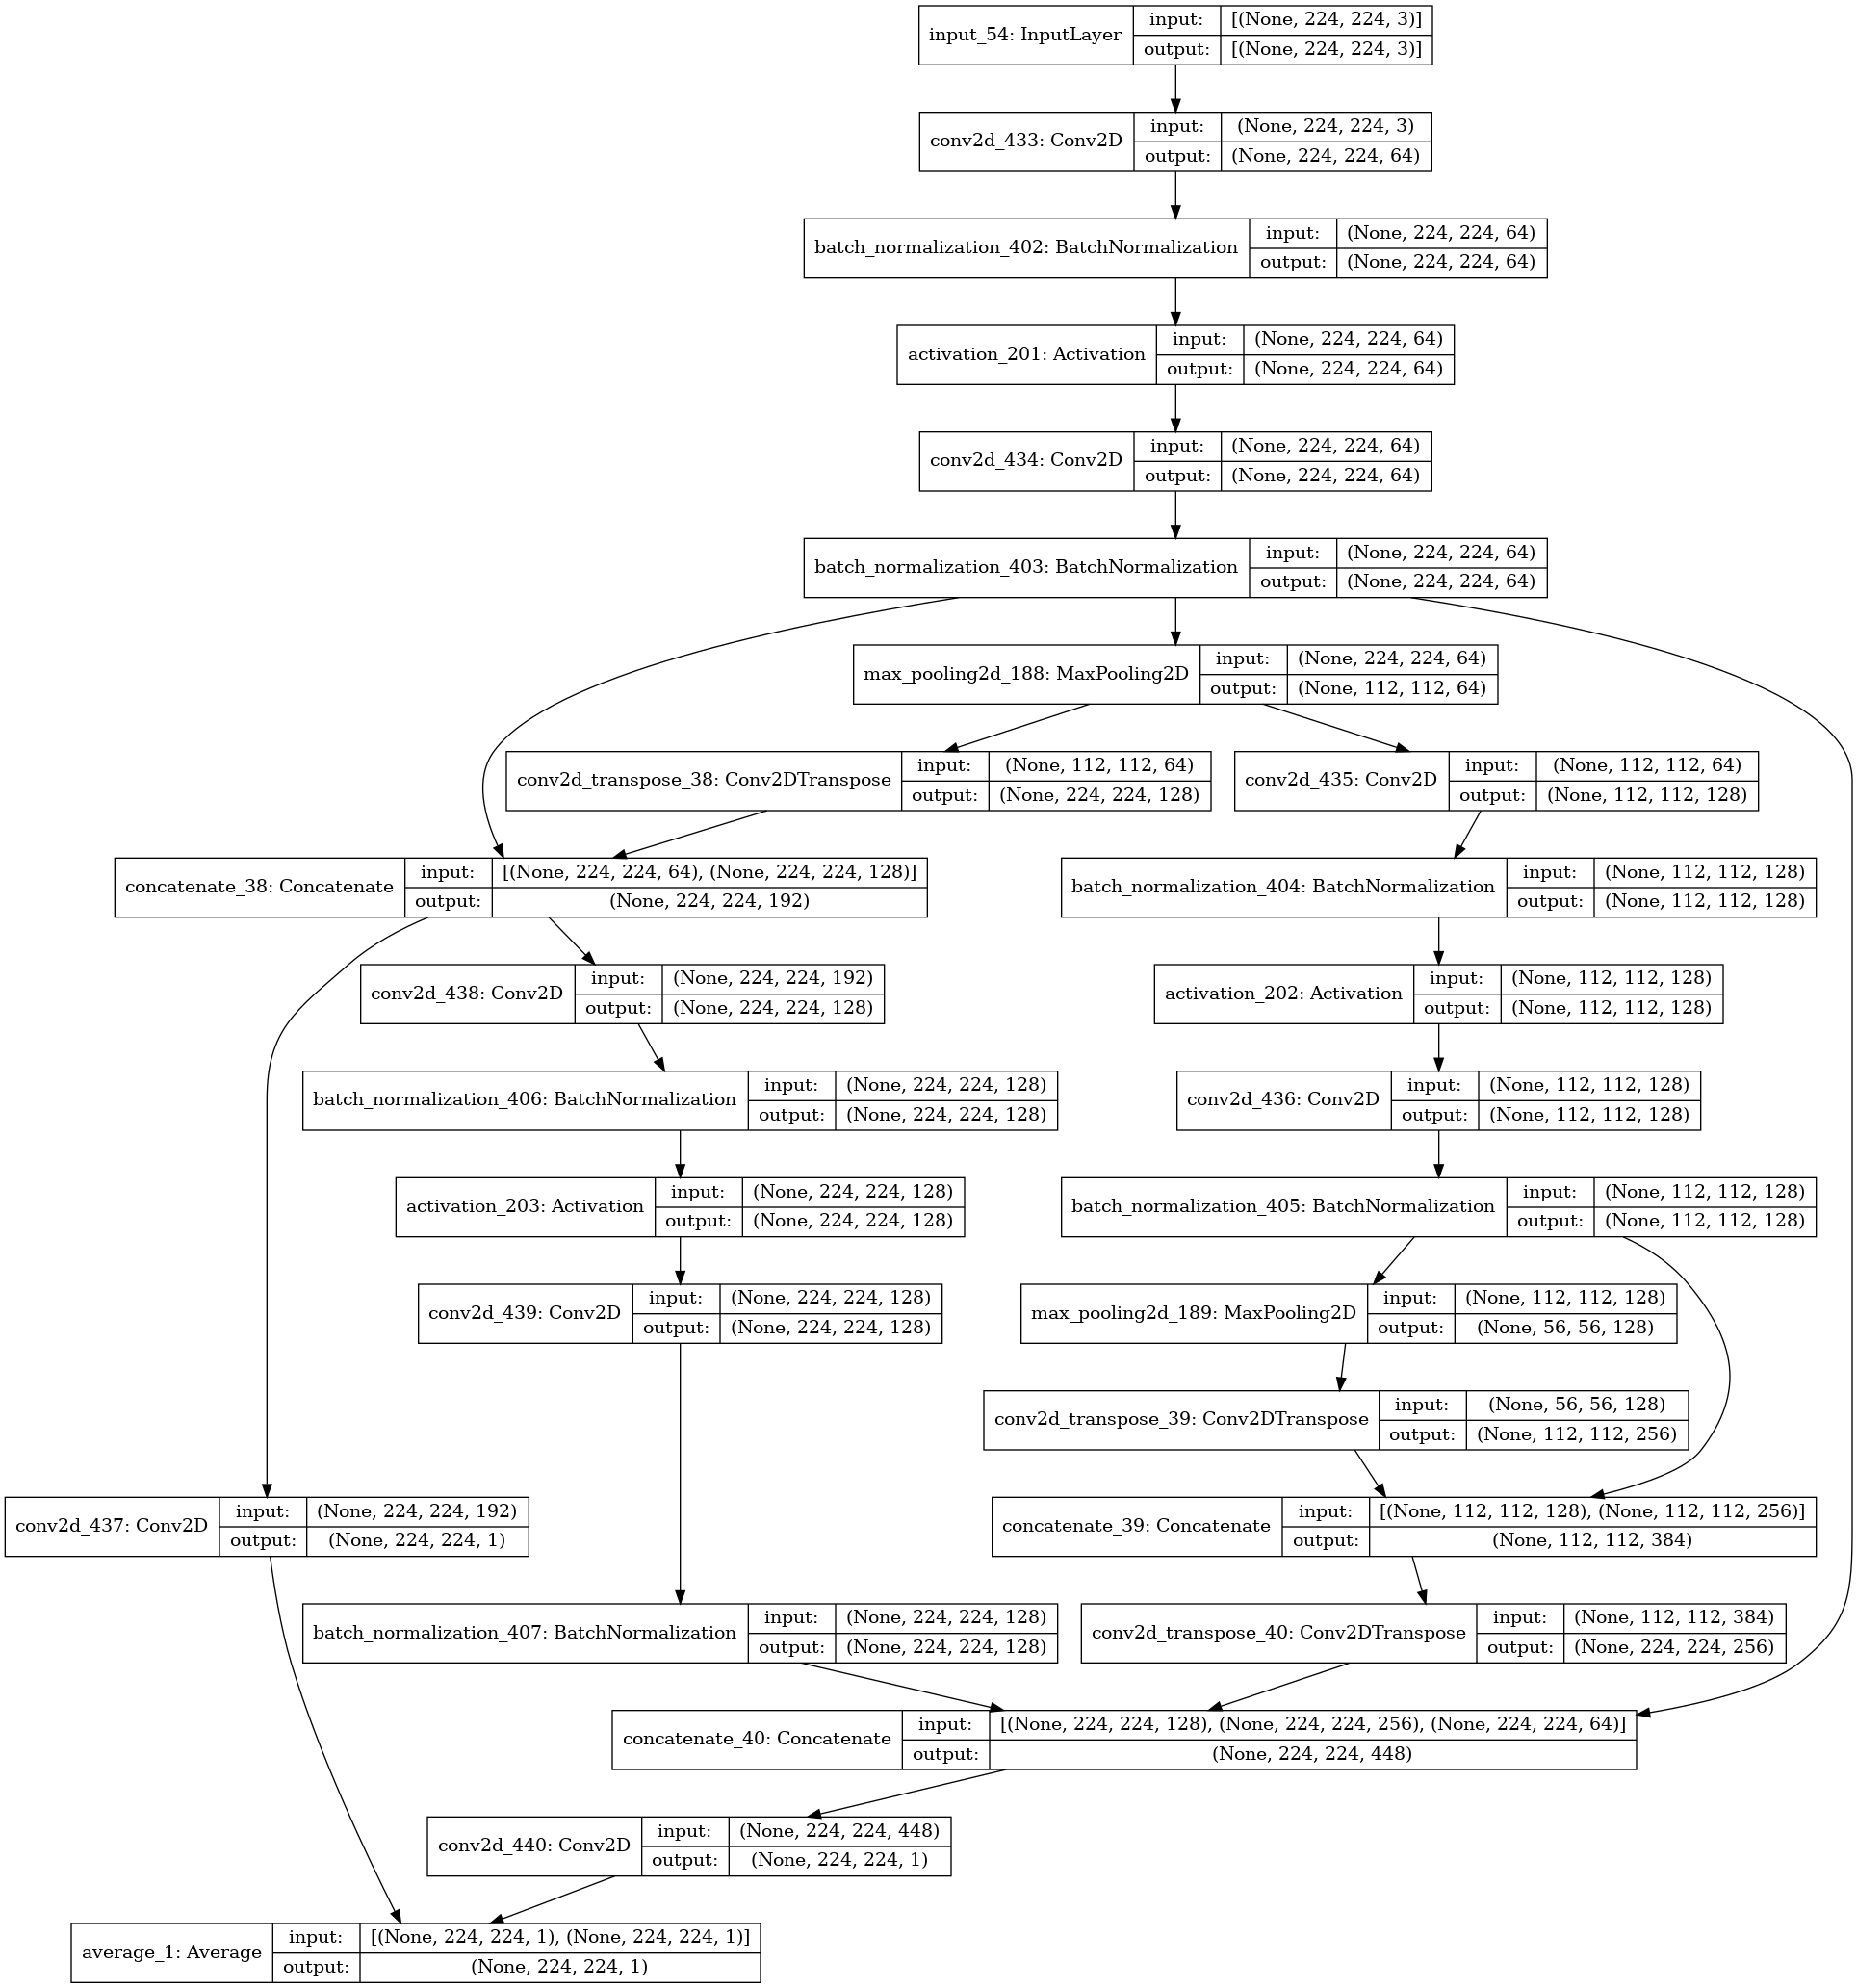

In [138]:
keras.utils.plot_model(UNet_pp_L2, show_shapes=True)

### U-net++ L4
---
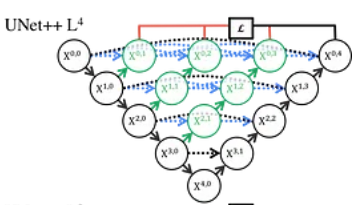

In [21]:
img_size=(224, 224)
num_classes=1
# filters = [64, 128, 256, 512, 1024]
filters = [32,64,128,256,512]


inputs = keras.Input(shape=img_size + (3,))

# Î≥ÄÏàòÎ™Ö Ï†ïÎ¶¨
# ÏßÑÌïú Í≤ÄÏùÄÏÉâ : x (Ïù∏ÏΩîÎçîÏóêÏÑúÎäî ÏïÑÎûòÎ°ú, ÎîîÏΩîÎçîÏóêÏÑúÎäî ÏúÑÎ°ú)
# Ï†êÏÑ† ÌååÎûÄÏÉâ : p (ÏòÜÏúºÎ°ú Í∞ÄÎäî Í≤ÉÎì§)  
# ÏßÑÌïú Ï¥àÎ°ùÏÉâ : u (ÏúÑÎ°ú Í∞ÄÎäî Í≤ÉÎì§) 
# Ìï©Ï≥êÏßÑ Ïù∏Ìíã : i
# Îπ®Í∞ÑÏÉâ (Ï∂úÎ†•Í∞í) : o

# xÏôÄ p Ï∞®Ïù¥Îäî max pooling Ï†ÅÏö© Ïó¨Î∂Ä

# Encoder Î∂ÄÎ∂Ñ

# X_0_0
x_0_0, p_0_0 = EncoderBlock(inputs, filters[0])

# X_1_0
u_1_0 = UpBlock(x_0_0, filters[1])
x_1_0, p_1_0 = EncoderBlock(x_0_0, filters[1])

# X_2_0
u_2_0 = UpBlock(x_1_0, filters[2])
x_2_0, p_2_0 = EncoderBlock(x_1_0, filters[2])

# X_3_0
u_3_0 = UpBlock(x_2_0, filters[3])
x_3_0, p_3_0 = EncoderBlock(x_2_0, filters[3])


# Ï¥àÎ°ùÏÉâ Î∂ÄÎ∂Ñ

# X_0_1
i_0_1 =  keras.layers.Concatenate()([p_0_0, u_1_0]) 
o_0_1 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_1)
p_0_1 = ConvBlock(i_0_1, filters[0])

# X_1_1
i_1_1 =  keras.layers.Concatenate()([p_1_0, u_2_0]) 
u_1_1 = UpBlock(i_1_1, filters[1])
p_1_1 = ConvBlock(i_1_1, filters[0])

# X_2_1
i_2_1 =  keras.layers.Concatenate()([p_2_0, u_3_0]) 
u_2_1 = UpBlock(i_2_1, filters[1])
p_2_1 = ConvBlock(i_2_1, filters[0])

# X_0_2
i_0_2 =  keras.layers.Concatenate()([p_0_1, u_1_1, p_0_0]) 
o_0_2 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_2)
p_0_2 = ConvBlock(i_0_2, filters[0])


# X_1_2
i_1_2 =  keras.layers.Concatenate()([p_1_1, u_2_1, p_1_0]) 
u_1_2 = UpBlock(i_1_2, filters[1])
p_1_2 = ConvBlock(i_1_2, filters[0])

# X_0_3
i_0_3 =  keras.layers.Concatenate()([p_0_1, u_1_2, p_0_0, p_0_2]) 
o_0_3 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_3)
p_0_3 = ConvBlock(i_0_3, filters[0])

# Decoder Î∂ÄÎ∂Ñ

# X_4_0
x_4_0 = DecoderBlock(x_3_0, [], filters[4])

# X_3_1
x_3_1 = DecoderBlock(x_4_0, [p_3_0], filters[3])

# X_2_2
x_2_2 = DecoderBlock(x_3_1, [p_2_1, p_2_0], filters[2])

# X_1_3
x_1_3 = DecoderBlock(x_2_2, [p_1_2, p_1_1, p_1_0], filters[1])

# X_0_4
i_0_4 =  keras.layers.Concatenate()([x_1_3, p_0_0, p_0_1, p_0_2, p_0_3])
o_0_4 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_4)

outputs = keras.layers.Average()([o_0_1, o_0_2, o_0_3, o_0_4])
UNet_pp_L4 = keras.Model(inputs, outputs)

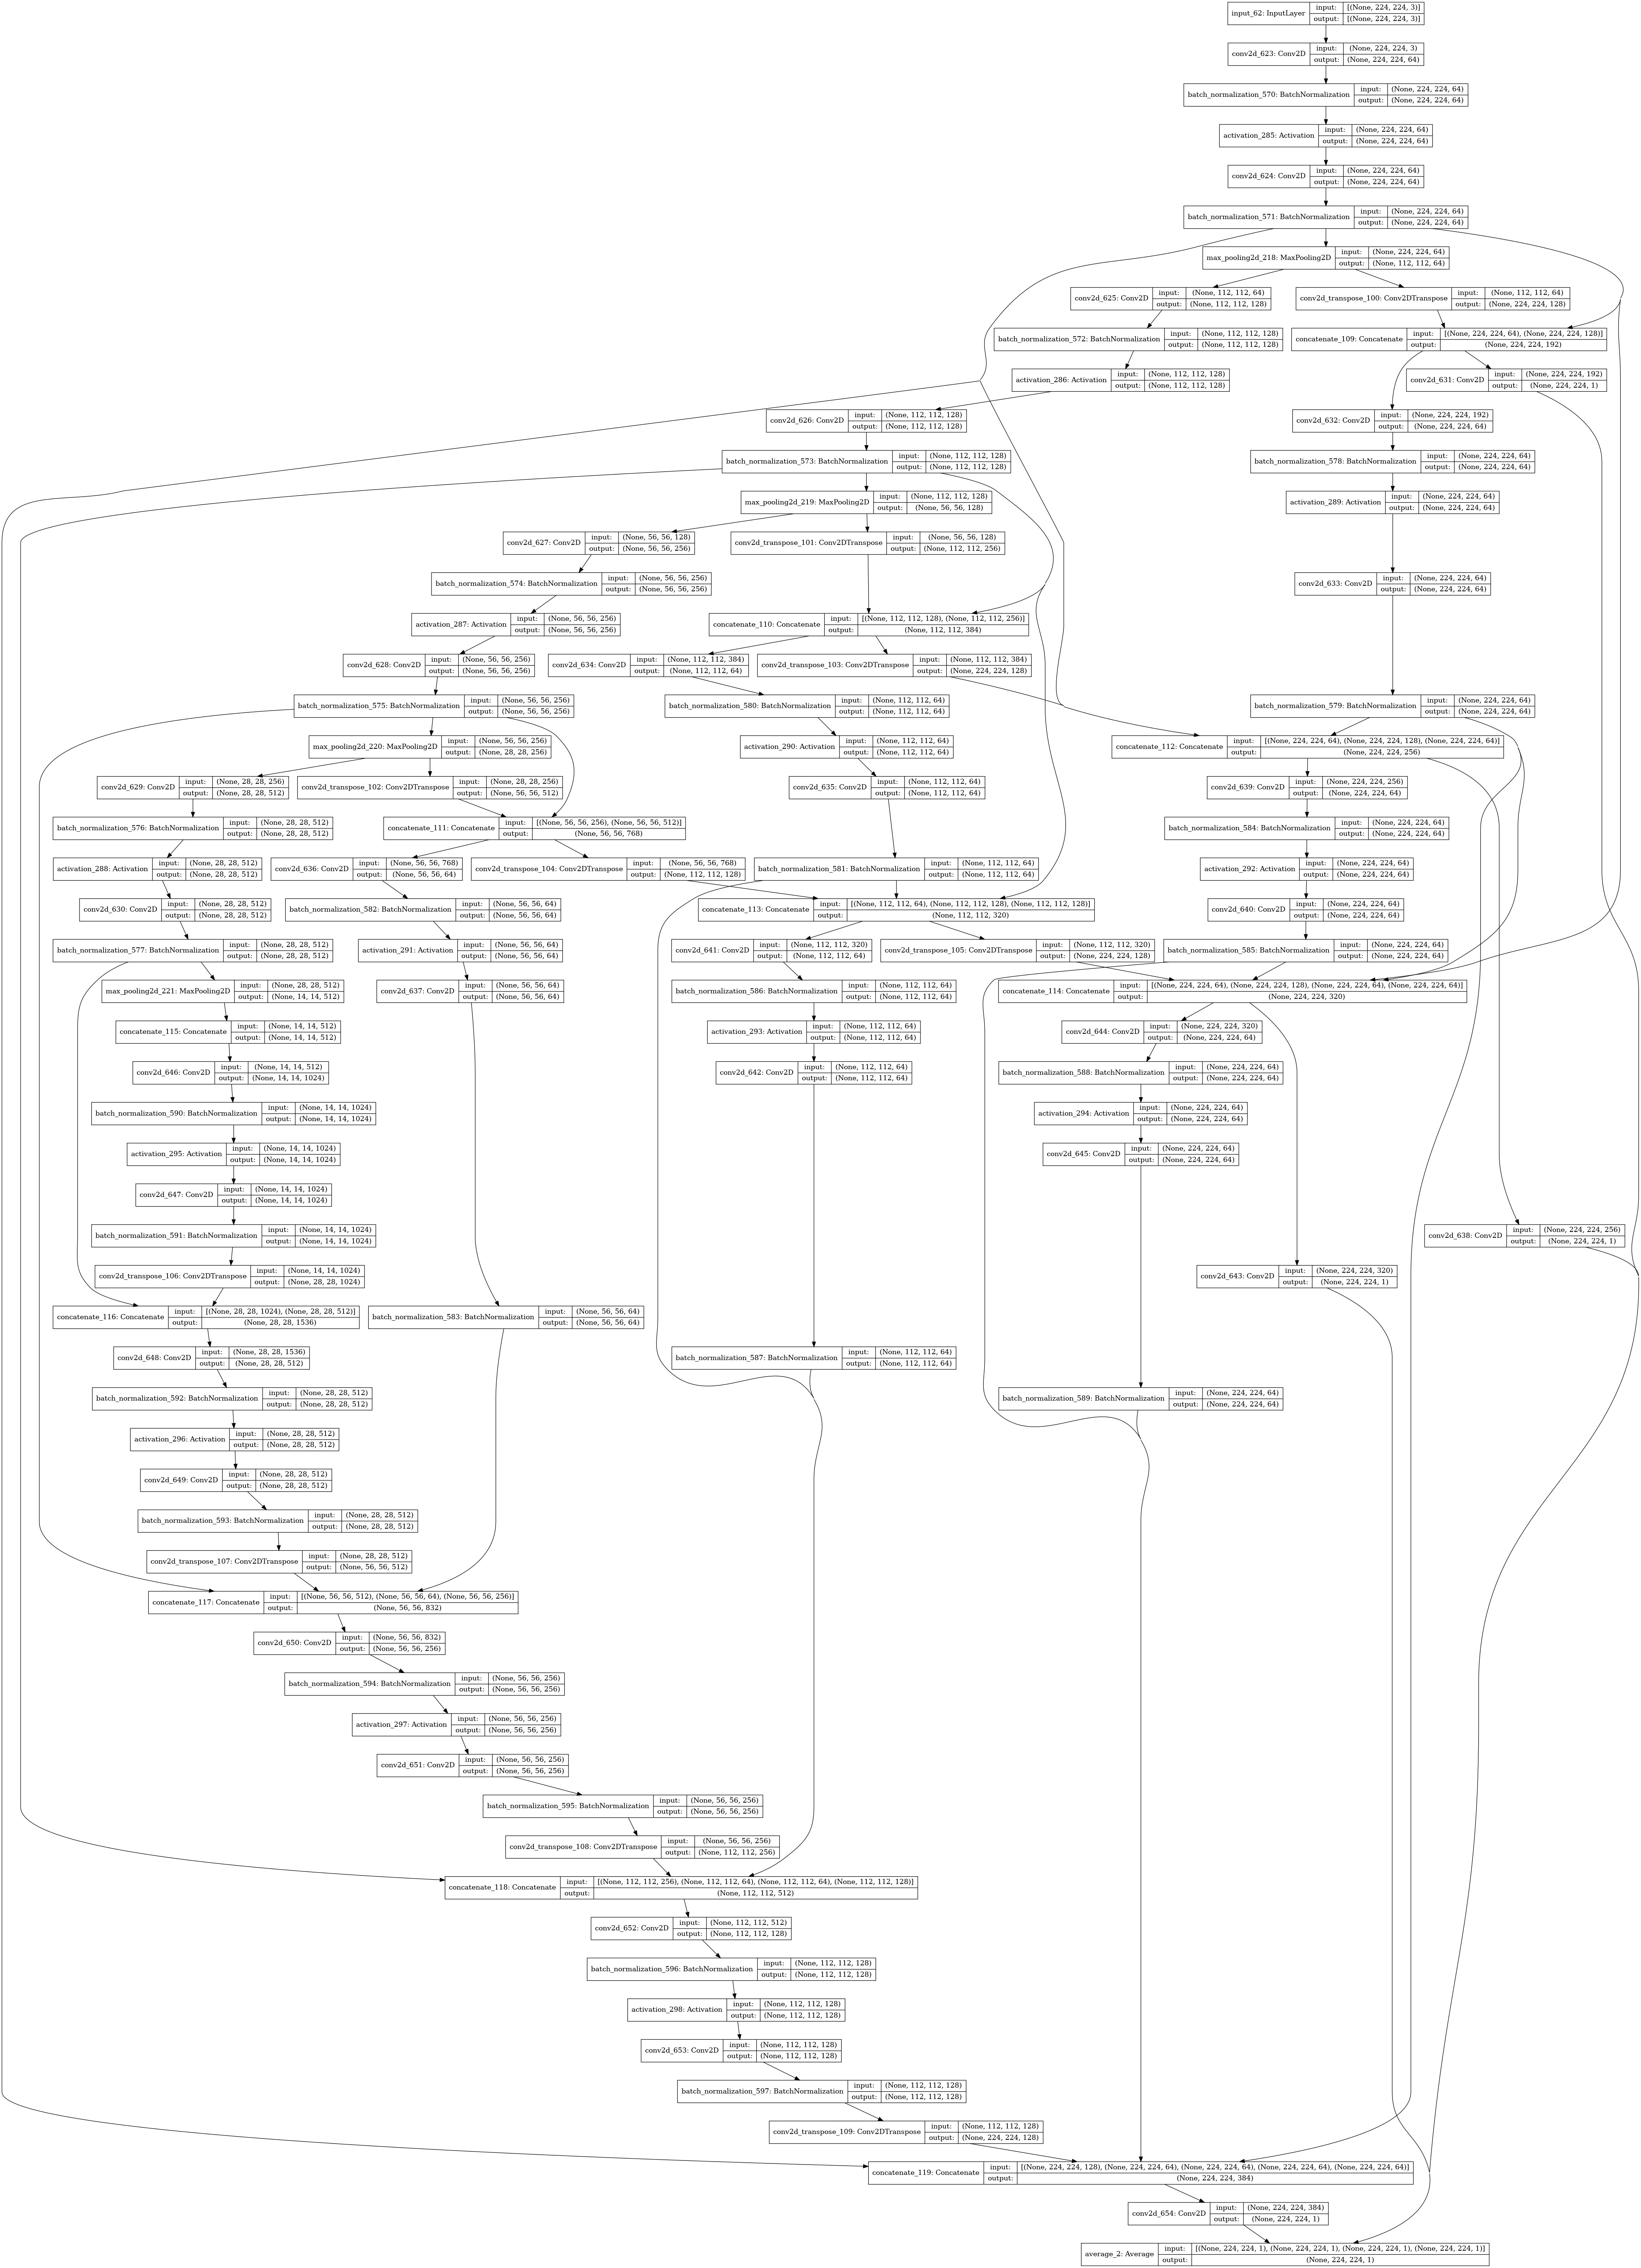

In [186]:
keras.utils.plot_model(UNet_pp_L4, show_shapes=True)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
# Ìï®ÏàòÌôî ÌïòÍ∏∞

def ConvBlock(x, n_filters):
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(n_filters, 3, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    return x

def EncoderBlock(x, n_filters):
    p = ConvBlock(x, n_filters)
    x = keras.layers.MaxPooling2D(2)(p)
    
    return x, p 

def DecoderBlock(x, skip, n_filters):
    x = keras.layers.Concatenate()([x, *skip]) 
    x = ConvBlock(x, n_filters)
    x = UpBlock(x, n_filters)
    
    return x

def UpBlock(x, n_filters):
    x = keras.layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(x)
    
    return x

def build_UNetPP(img_size=(224, 224), num_classes=1, filters = [64, 128, 256, 512, 1024]):
    inputs = keras.Input(shape=img_size + (3,))

    # Î≥ÄÏàòÎ™Ö Ï†ïÎ¶¨
    # ÏßÑÌïú Í≤ÄÏùÄÏÉâ : x (Ïù∏ÏΩîÎçîÏóêÏÑúÎäî ÏïÑÎûòÎ°ú, ÎîîÏΩîÎçîÏóêÏÑúÎäî ÏúÑÎ°ú)
    # Ï†êÏÑ† ÌååÎûÄÏÉâ : p (ÏòÜÏúºÎ°ú Í∞ÄÎäî Í≤ÉÎì§)  
    # ÏßÑÌïú Ï¥àÎ°ùÏÉâ : u (ÏúÑÎ°ú Í∞ÄÎäî Í≤ÉÎì§) 
    # Ìï©Ï≥êÏßÑ Ïù∏Ìíã : i
    # Îπ®Í∞ÑÏÉâ (Ï∂úÎ†•Í∞í) : o

    # xÏôÄ p Ï∞®Ïù¥Îäî max pooling Ï†ÅÏö© Ïó¨Î∂Ä

    # Encoder Î∂ÄÎ∂Ñ
    
    # X_0_0
    x_0_0, p_0_0 = EncoderBlock(inputs, filters[0])

    # X_1_0
    u_1_0 = UpBlock(x_0_0, filters[1])
    x_1_0, p_1_0 = EncoderBlock(x_0_0, filters[1])

    # X_2_0
    u_2_0 = UpBlock(x_1_0, filters[2])
    x_2_0, p_2_0 = EncoderBlock(x_1_0, filters[2])

    # X_3_0
    u_3_0 = UpBlock(x_2_0, filters[3])
    x_3_0, p_3_0 = EncoderBlock(x_2_0, filters[3])


    # Ï¥àÎ°ùÏÉâ Î∂ÄÎ∂Ñ
    
    # X_0_1
    i_0_1 =  keras.layers.Concatenate()([p_0_0, u_1_0]) 
    o_0_1 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_1)
    p_0_1 = ConvBlock(i_0_1, filters[0])

    # X_1_1
    i_1_1 =  keras.layers.Concatenate()([p_1_0, u_2_0]) 
    u_1_1 = UpBlock(i_1_1, filters[1])
    p_1_1 = ConvBlock(i_1_1, filters[0])

    # X_2_1
    i_2_1 =  keras.layers.Concatenate()([p_2_0, u_3_0]) 
    u_2_1 = UpBlock(i_2_1, filters[1])
    p_2_1 = ConvBlock(i_2_1, filters[0])

    # X_0_2
    i_0_2 =  keras.layers.Concatenate()([p_0_1, u_1_1, p_0_0]) 
    o_0_2 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_2)
    p_0_2 = ConvBlock(i_0_2, filters[0])


    # X_1_2
    i_1_2 =  keras.layers.Concatenate()([p_1_1, u_2_1, p_1_0]) 
    u_1_2 = UpBlock(i_1_2, filters[1])
    p_1_2 = ConvBlock(i_1_2, filters[0])

    # X_0_3
    i_0_3 =  keras.layers.Concatenate()([p_0_1, u_1_2, p_0_0, p_0_2]) 
    o_0_3 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_3)
    p_0_3 = ConvBlock(i_0_3, filters[0])

    # Decoder Î∂ÄÎ∂Ñ

    # X_4_0
    x_4_0 = DecoderBlock(x_3_0, [], filters[4])

    # X_3_1
    x_3_1 = DecoderBlock(x_4_0, [p_3_0], filters[3])

    # X_2_2
    x_2_2 = DecoderBlock(x_3_1, [p_2_1, p_2_0], filters[2])

    # X_1_3
    x_1_3 = DecoderBlock(x_2_2, [p_1_2, p_1_1, p_1_0], filters[1])

    # X_0_4
    i_0_4 =  keras.layers.Concatenate()([x_1_3, p_0_0, p_0_1, p_0_2, p_0_3])
    o_0_4 = keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(i_0_4)

    outputs = keras.layers.Average()([o_0_1, o_0_2, o_0_3, o_0_4])
    model = keras.Model(inputs, outputs)

    return model

## ÌïôÏäµÏãúÌÇ§Í∏∞

In [ ]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetPP.h5'

model = build_UNetPP()
model.compile(optimizer = Adam(1e-4), loss ='binary_crossentropy')

In [11]:
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=30,
 )

model.save(model_path) 

Epoch 1/30
43/43 [==============================] - 23s 540ms/step - loss: 11.8539 - val_loss: 11.7388
Epoch 2/30
43/43 [==============================] - 24s 548ms/step - loss: 11.6162 - val_loss: 11.7388
Epoch 3/30
43/43 [==============================] - 23s 541ms/step - loss: 11.8731 - val_loss: 11.7388
Epoch 4/30
43/43 [==============================] - 23s 539ms/step - loss: 11.9798 - val_loss: 11.7388
Epoch 5/30
43/43 [==============================] - 23s 543ms/step - loss: 11.9221 - val_loss: 11.7388
Epoch 6/30
43/43 [==============================] - 23s 542ms/step - loss: 11.6762 - val_loss: 11.7388
Epoch 7/30
43/43 [==============================] - 23s 542ms/step - loss: 11.8195 - val_loss: 11.7388
Epoch 8/30
43/43 [==============================] - 23s 542ms/step - loss: 11.6839 - val_loss: 11.7388
Epoch 9/30
43/43 [==============================] - 23s 541ms/step - loss: 11.9293 - val_loss: 11.7388
Epoch 10/30
43/43 [==============================] - 23s 542ms/step - los

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


loss func Ïù¥ binary crossentropy ÏùºÎïå lossÍ∞Ä ÏïàÏ§ÑÏñ¥Îì¨

In [15]:
from tensorflow.keras import backend as K

# binary + dice_coef ÌòïÌÉúÎ°ú loss func Ï†ïÏùò

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [22]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetPP.h5'

filters = [32,64,128,256,512]

model = build_UNetPP(filters=filters)
model.compile(optimizer=Adam(1e-4), loss=bce_dice_loss)

In [23]:
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=30,
 )

model.save(model_path) 

Epoch 1/30
43/43 [==============================] - 19s 236ms/step - loss: 5.6175 - val_loss: 5.4983
Epoch 2/30
43/43 [==============================] - 9s 218ms/step - loss: 5.7224 - val_loss: 5.4983
Epoch 3/30
43/43 [==============================] - 10s 220ms/step - loss: 5.6193 - val_loss: 5.4983
Epoch 4/30
43/43 [==============================] - 10s 221ms/step - loss: 5.5018 - val_loss: 5.4983
Epoch 5/30
43/43 [==============================] - 10s 222ms/step - loss: 5.5555 - val_loss: 5.4983
Epoch 6/30
43/43 [==============================] - 10s 221ms/step - loss: 5.6045 - val_loss: 5.4983
Epoch 7/30
43/43 [==============================] - 10s 221ms/step - loss: 5.6315 - val_loss: 5.4983
Epoch 8/30
43/43 [==============================] - 10s 221ms/step - loss: 5.5567 - val_loss: 5.4983
Epoch 9/30
43/43 [==============================] - 10s 220ms/step - loss: 5.6228 - val_loss: 5.4983
Epoch 10/30
 3/43 [=>............................] - ETA: 7s - loss: 4.9528

KeyboardInterrupt: 

Ïó¨Ï†ÑÌûà ÌïôÏäµÏù¥ ÏïàÎêúÎã§.   

# ÌöåÍ≥†
---

üòÄ    
Î™®Îç∏ÏùÑ ÏßúÎäîÍ≤å Ï≤òÏùåÏóî Ïñ¥Î†§ÏõåÎ≥¥ÏòÄÎäîÎç∞, Î™®Îç∏Ïùò Íµ¨Ï°∞Î•º Ïù¥Ìï¥ÌïòÍ≥† ÌïòÎÇòÏî© ÏßúÎã§Î≥¥Îãà ÏôÑÏÑ±Ìï† Ïàò ÏûàÏóàÎã§.   
ÎπÑÎ°ù ÌïôÏäµÏù¥ ÏïàÎêòÎäî Î¨∏Ï†úÍ∞Ä ÏûàÏóàÏßÄÎßå, Ï¢ãÏùÄ Í≤ΩÌóòÏù¥ ÎêêÎã§.   
   
üòÖ    
ÏïÑÏâ¨Ïö¥ Ï†êÏùÄ Î¨∏Ï†úÎ•º ÌååÏïÖÌïòÏßÄ Î™ªÌñàÎã§Îäî Í≤É...   
Î™®Îç∏Ïù¥ ÏóÑÏ≤≠ Î≥µÏû°Ìï¥ÏßÄÎãàÍπå Ïñ¥ÎîîÏÑúÎ∂ÄÌÑ∞ ÏûòÎ™ªÏßúÎäîÏßÄ ÌååÏïÖÌïòÍ∏∞Í∞Ä Ïñ¥Î†µÎã§.   
1. ÏùºÎã® Îã§Î•∏ ÏÇ¨ÎûåÏù¥ Ïß† Î™®Îç∏ÏùÑ Î≥¥Í≥† Ïù¥Ìï¥Ìï¥Î≥¥Í≥† 
2. ÎÇ¥Í∞Ä Ïß†Í±∞Îûë ÎπÑÍµêÌï¥Î≥¥Í≥†
3. ÏàòÏ†ïÌï¥Î¥êÏïºÌï† Í≤É Í∞ôÎã§.   
    
ÏïûÏúºÎ°ú Î™®Îç∏ÏùÑ ÎßéÏù¥ ÏßúÍ≤å Îê†ÌÖêÎç∞, Ïù¥Î•º Ï¢Ä Îçî Ìö®Ïú®Ï†ÅÏúºÎ°ú Ìï† Ïàò ÏûàÎäî Î∞©Î≤ïÏóê ÎåÄÌï¥ Í≥†ÎØºÌï¥Î¥êÏïºÍ≤†Îã§.  